This is the kaggle version of a Pierre Auger Observatory Open Data notebook. You can run it by clicking on "Copy and Edit" in the top right corner.

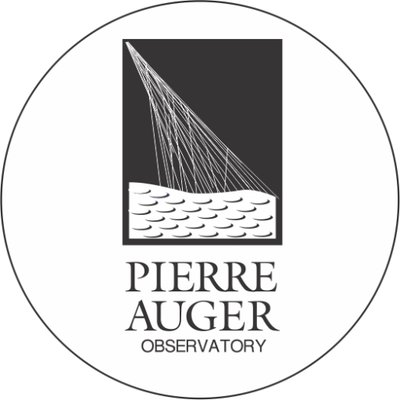
# Tutorial: How we reconstruct radio signals



The aim of this notebook is to explore the traces we measure at the Pierre Auger Observatory and how we reconstruct the true signals.

## Import some standard python libraries that contain basic functions used along the notebook.

In [1]:
import json
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import hilbert, iirnotch, filtfilt

# Jupyter/ IPython formatting
from IPython.display import Math, Latex, display

In [2]:
# Default values for plots
plt.rcParams["figure.figsize"] = [14, 9] # figure width and height
plt.rcParams["font.size"] = 20

## Load an event file from the zipped or unzipped folder using a json parser

Select an event from the list

In [5]:
filename = 'Auger_radio_example_file.json' #select an event by file name


with open(filename, "r") as f:
    data = json.load(f) 


In [6]:
rdstations = pd.DataFrame(data['rdstations'])
display(rdstations.head(3))


id  sampling_rate  signal_start  signal_stop  noise_start  noise_stop  \
0  30191            4.0        3300.0       3520.0       6000.0      8000.0   
1  30192            4.0        3300.0       3520.0       6000.0      8000.0   
2  30193            4.0        3300.0       3520.0       6000.0      8000.0   

                                                 Ch0  \
0  [7, 9, 5, 6, 9, 6, 3, 7, 9, 8, 5, 5, 4, 5, 9, ...   
1  [10, 2, 7, 11, 4, 4, 12, 10, 2, 7, 13, 8, 4, 9...   
2  [-1, 2, -3, -5, -1, -1, -3, 0, -1, -3, -1, 0, ...   

                                                 Ch1  
0  [2, 1, -5, -2, 4, 0, -4, 1, 2, -6, -7, 3, 4, -...  
1  [-3, -6, -4, -2, -4, -6, -3, -2, -5, -6, -3, -...  
2  [-2, 2, -3, -8, -4, 1, -4, -7, 0, 0, -7, -7, 0...

## Let's have a look at the data for one example station for the two different channels

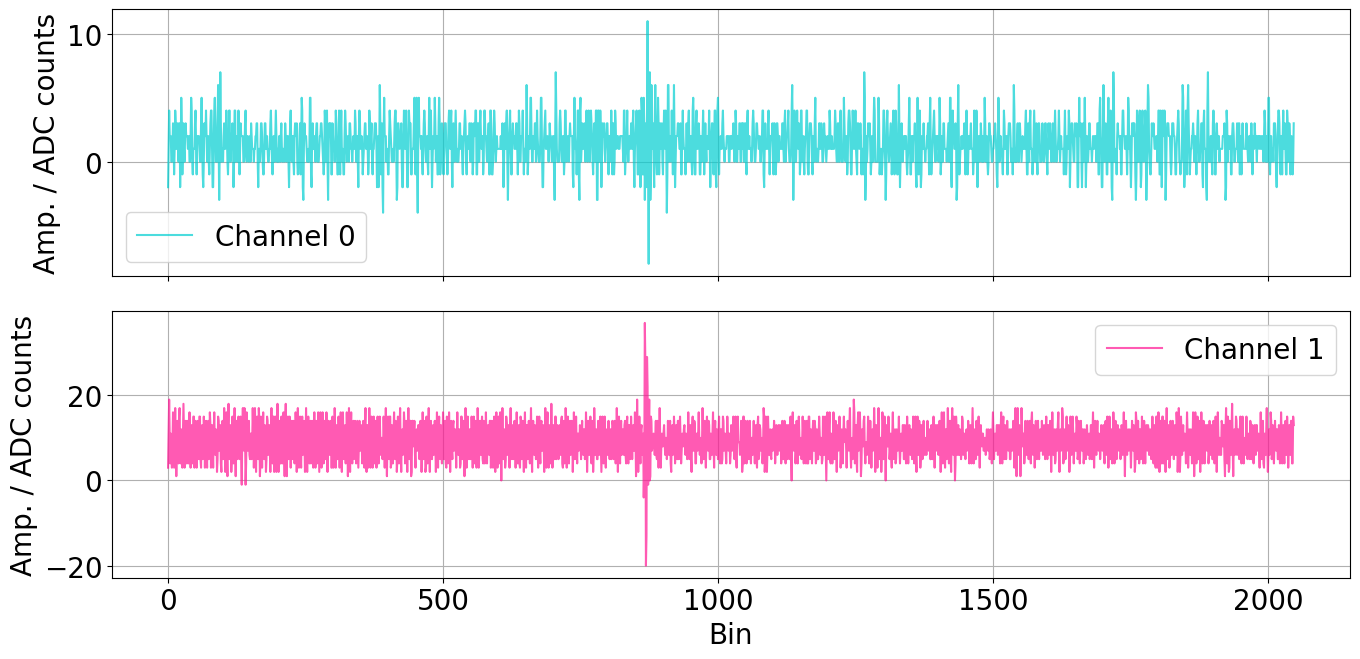

In [7]:
rd = rdstations.iloc[7]

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols= 1, sharex=True, figsize=(14, 7))

ax1.plot(rd['Ch0'], color = 'darkturquoise', alpha = 0.7, label = 'Channel 0')
ax2.plot(rd['Ch1'], color = 'deeppink', alpha = 0.7, label = 'Channel 1')

ax2.set_xlabel('Bin')

for ax in [ax1, ax2]:
    ax.set_ylabel('Amp. / ADC counts')
    ax.grid()
    ax.legend()

plt.tight_layout()
plt.show()

### Maybe a closer look on the signal and what noise normally looks like

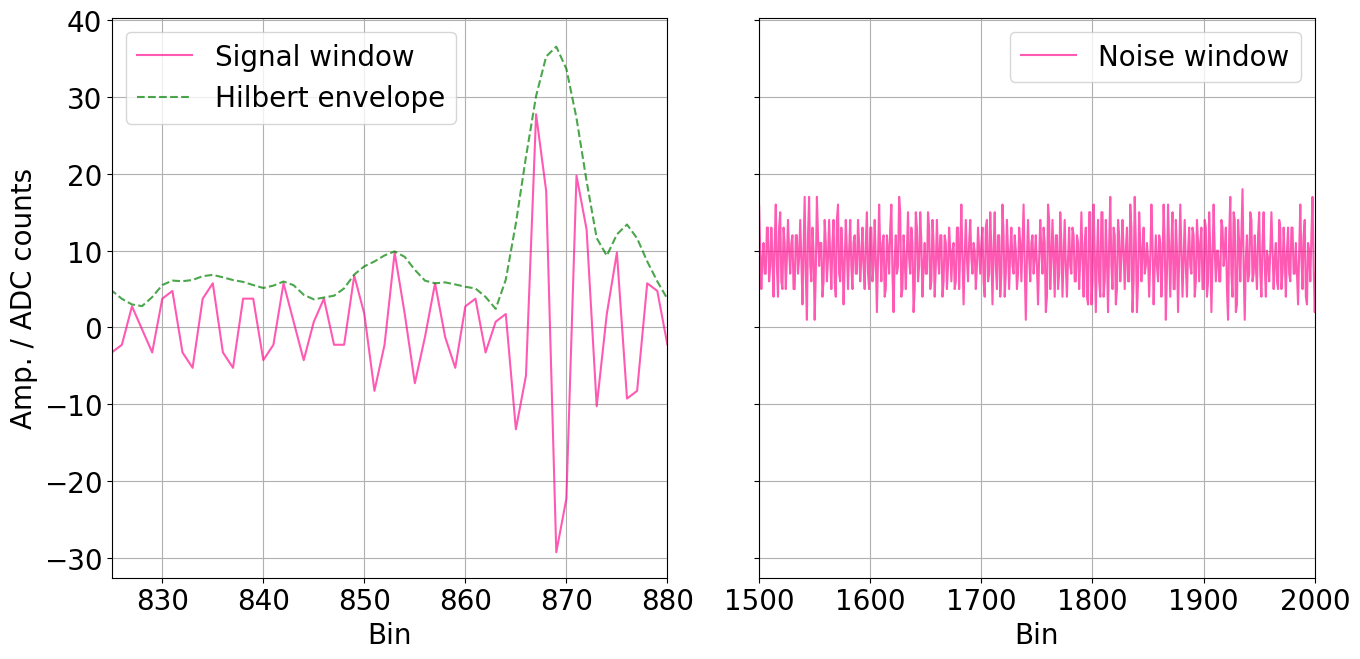

In [8]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols= 2, sharey=True, figsize=(14, 7))

ax1.plot(rd['Ch1']-np.mean(rd['Ch1']), color = 'deeppink', alpha = 0.7, label = 'Signal window')
ax1.plot(np.abs(hilbert(rd['Ch1']-np.mean(rd['Ch1']))), color = 'green', linestyle = 'dashed', alpha = 0.7, label = 'Hilbert envelope')

ax2.plot(rd['Ch1'], color = 'deeppink', alpha = 0.7, label = 'Noise window')


for ax in [ax1, ax2]:
    ax.grid()
    ax.legend()
    ax.set_xlabel('Bin')

ax1.set_ylabel('Amp. / ADC counts')

ax1.set_xlim(rd['signal_start']/rd['sampling_rate'], rd['signal_stop']/rd['sampling_rate'])
ax2.set_xlim(rd['noise_start']/rd['sampling_rate'], rd['noise_stop']/rd['sampling_rate'])

plt.tight_layout()
plt.show()

### We clearly see a signal in the signal window. But we also observe oscillations in both parts of the trace. Is it maybe some artificial noise in there? A Fast-Fourier-Transformation (FFT) will tell us more.

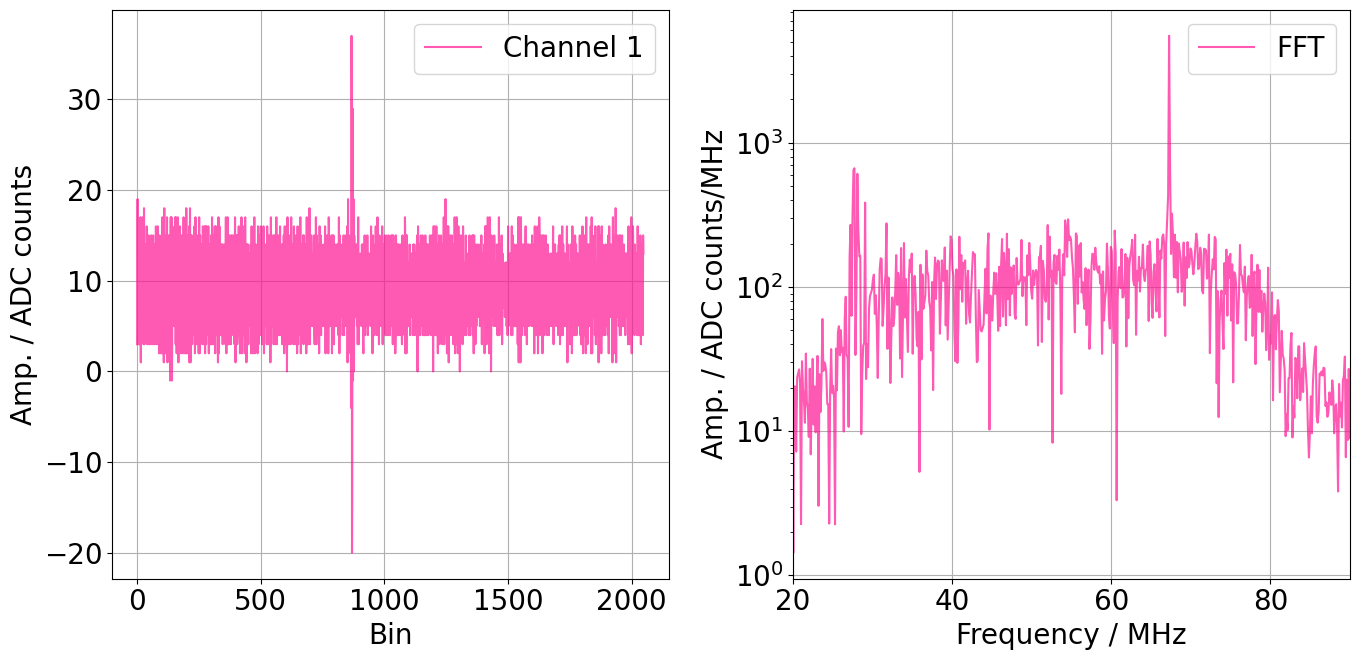

In [9]:
sampling_frequency = 1/(rd['sampling_rate']*1e-9)  # sampling rate in ns

frequencies = np.arange(len(rd["Ch1"]))/(len(rd["Ch1"])) * sampling_frequency

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols= 2, figsize=(14, 7))

ax1.plot(rd['Ch1'], color = 'deeppink', alpha = 0.7, label = 'Channel 1')
ax2.plot(frequencies[1:]/1e6, np.abs(np.fft.fft(rd["Ch1"]))[1:], color = 'deeppink', alpha = 0.7, label = 'FFT')


for ax in [ax1, ax2]:
    ax.grid()
    ax.legend()


ax1.set_xlabel('Bin')
ax2.set_xlabel('Frequency / MHz')
ax1.set_ylabel('Amp. / ADC counts')
ax2.set_ylabel('Amp. / ADC counts/MHz')

ax2.set_xlim(20,90)
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

### What do we see? Generally, we are sensitive in the region of 30-80 MHz, coming from our antenna design and in particular our bandpass filter. Now we see strong amplitudes around 27 MHz and at 67.3 MHz. 27 MHz is a common citizien band, remote controls or walky-talkies work with this frequency. Much stronger is the 67.3 MHz line, which is caused by a local TV station in Malargüe.

### We can apply a so-called notch filter to remove the human-made frequencies.

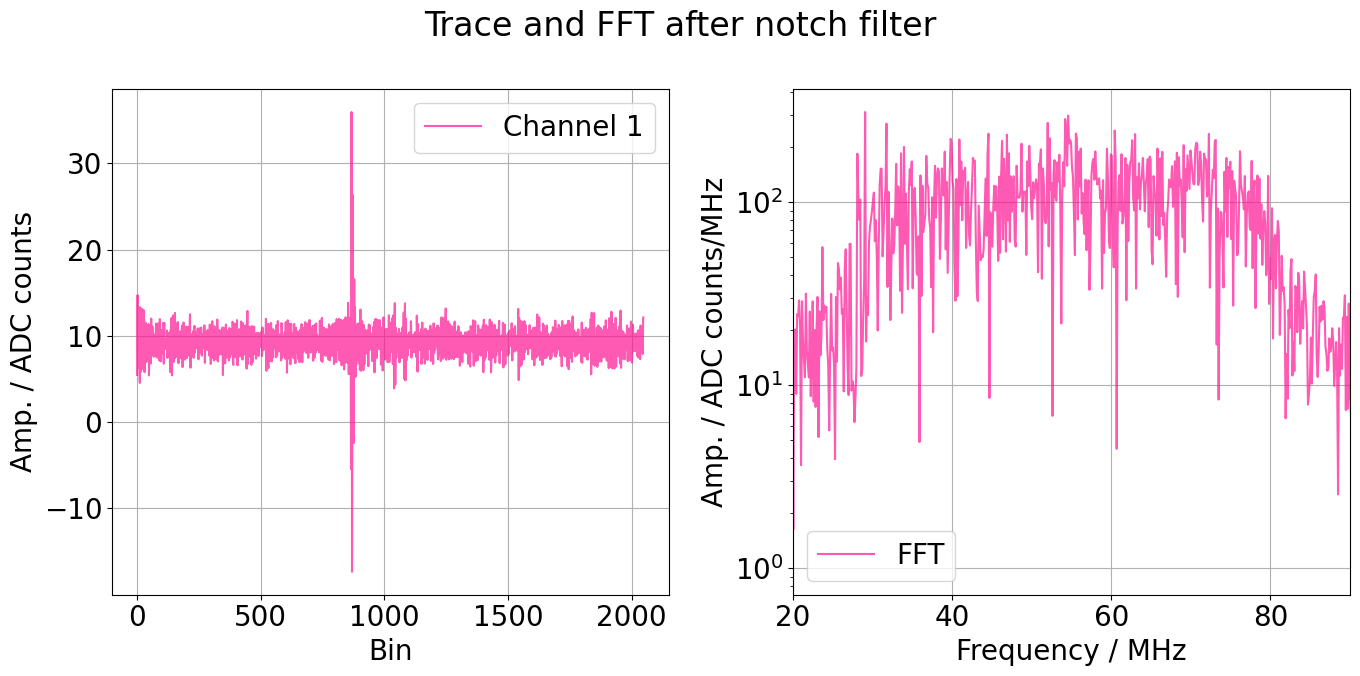

In [10]:

f_rem = [27.6e6, 67.3e6] ### frequencies to remove

q = [20.0, 50] ### how well defined are the frequencies, 27MHz is a bit broader, it has to have a lower q factor


signal_filtered_ch0 = np.array(rd['Ch0'])
signal_filtered_ch1 = np.array(rd['Ch1'])

for i in range(len(q)):
    b, a = iirnotch(f_rem[i], q[i], sampling_frequency)
    signal_filtered_ch0 = filtfilt(b, a, signal_filtered_ch0)

for i in range(len(q)):
    b, a = iirnotch(f_rem[i], q[i], sampling_frequency)
    signal_filtered_ch1 = filtfilt(b, a, signal_filtered_ch1)


fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols= 2, figsize=(14, 7))

ax1.plot(signal_filtered_ch1, color = 'deeppink', alpha = 0.7, label = 'Channel 1')
ax2.plot(frequencies[1:]/1e6, np.abs(np.fft.fft(signal_filtered_ch1))[1:], color = 'deeppink', alpha = 0.7, label = 'FFT')


for ax in [ax1, ax2]:
    ax.grid()
    ax.legend()


ax1.set_xlabel('Bin')
ax2.set_xlabel('Frequency / MHz')
ax1.set_ylabel('Amp. / ADC counts')
ax2.set_ylabel('Amp. / ADC counts/MHz')

ax2.set_xlim(20,90)
ax2.set_yscale('log')

plt.suptitle('Trace and FFT after notch filter')
plt.tight_layout()
plt.show()

### We see that the FFT does not show 27 and 67 MHz and also the trace looks less noisy.

### Next, we want to account for the antenna pattern. What does that mean? Imagine your TV remote controle at home (which is also nothing else than an antenna). You need to point it at your TV, otherwise it will not work. This means your remote controle has a high sensitivity in the direction that you are pointing and nearly no sensitivity in the opposite direction. This is what we call the antenna pattern. You can imagine the same principle for our antennas at Auger, in some directions they are less sensitive. But to reconstruct the true signal that arrives, we need to account for this insensitivity. This we do by dividing our signal by our antenna pattern. Let's have a look at our antenna pattern.

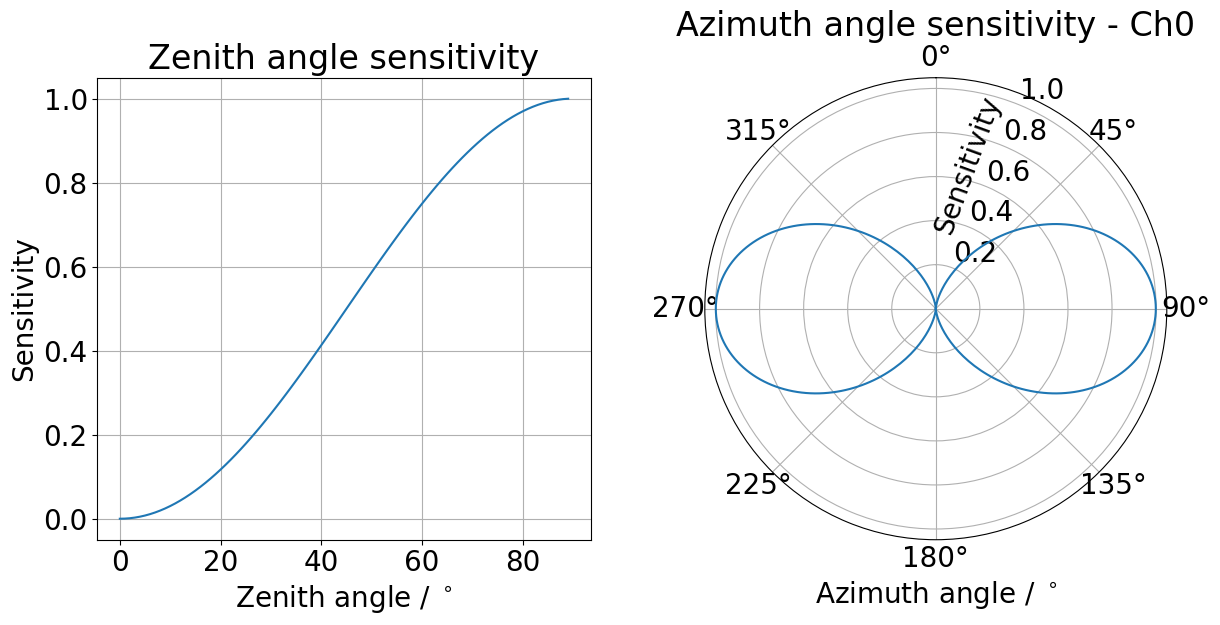

In [11]:
def antenna_gain(theta, phi, phi0=90):
    """
    theta: Zenith angle in degrees
    phi: Azimuth angle in degrees
    phi0: Orientation of antenna maximum (e.g., 90° = NS)

    Returns relative antenna gain
    """
    theta_rad = np.radians(theta)
    phi_rad = np.radians(phi)
    phi0_rad = np.radians(phi0)
    
    gain = (np.sin(theta_rad))**2 * (np.cos(phi_rad - phi0_rad))**2
    return gain



fig = plt.figure(figsize=(14, 6))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122, projection='polar')

ax1.set_xlabel(r"Zenith angle / $^\circ$")
ax1.set_ylabel(r"Sensitivity")

ax1.plot(antenna_gain(np.arange(0,90), 90, 90))

ax1.set_title('Zenith angle sensitivity')
ax1.grid()

ax2.set_theta_zero_location('N')  # 0° at East
ax2.set_theta_direction(-1)
ax2.set_xlabel(r"Azimuth angle / $^\circ$")
ax2.set_title('Azimuth angle sensitivity - Ch0')


label_position=ax2.get_rlabel_position()
ax2.text(np.radians(label_position-10),ax2.get_rmax()/1.5,'Sensitivity',
        rotation=70,ha='center',va='center')

ax2.plot(np.deg2rad(np.arange(0,360)),antenna_gain(88, np.arange(0,360), 90))

plt.show()



### Now we have to just divide our signal by the antenna pattern. We just need to know, where the signal comes from. For this, we take the arrival direction from the particle detector.

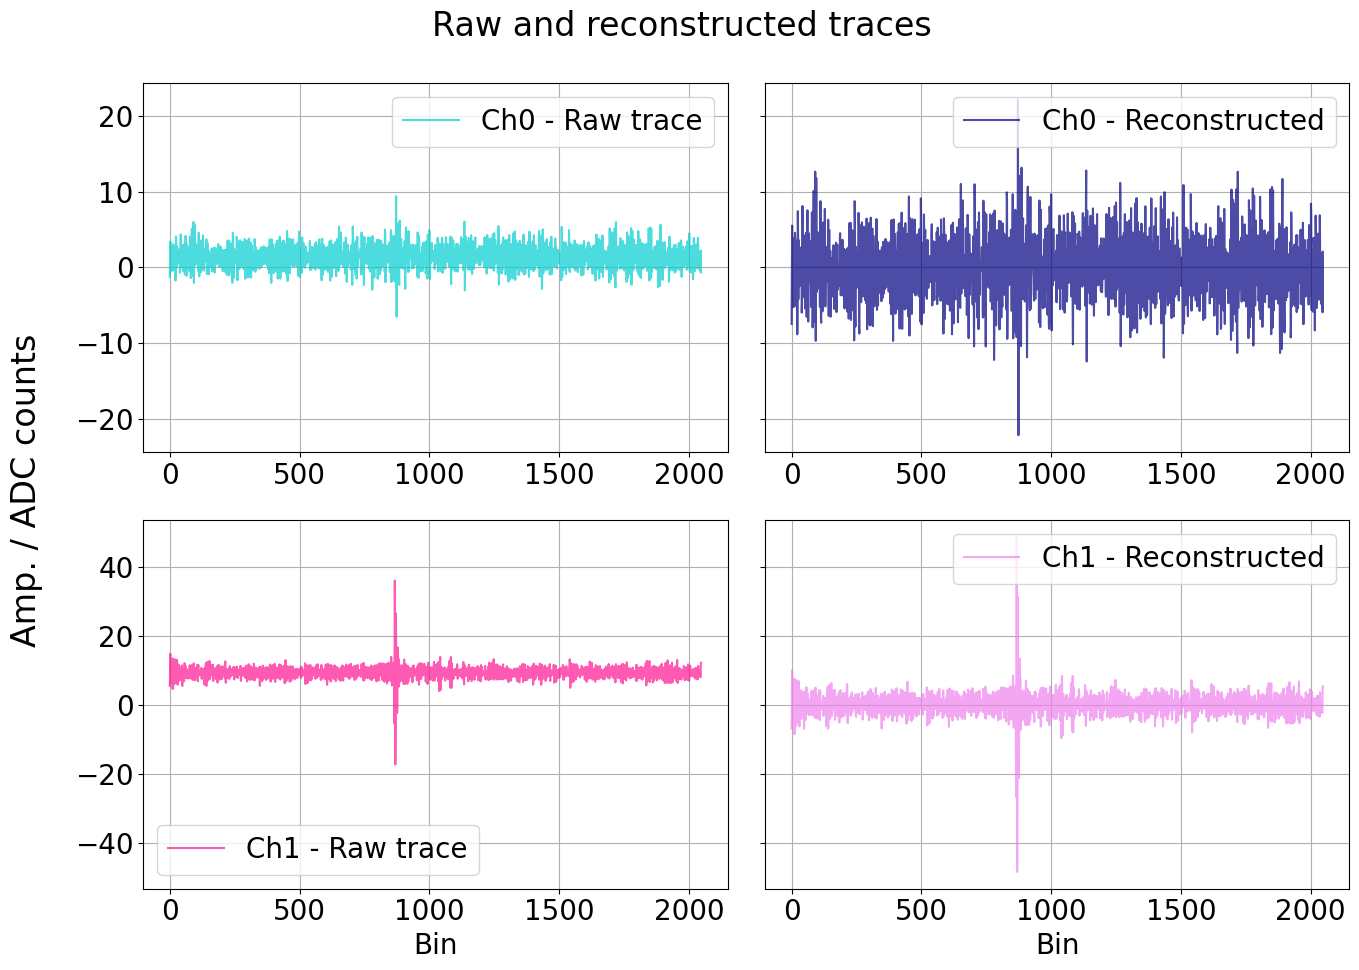

In [12]:


signal_filtered_corrected_ch0 = (signal_filtered_ch0-np.mean(signal_filtered_ch0)) / antenna_gain(data['sdrec']['theta'],data['sdrec']['phi'], 90)
signal_filtered_corrected_ch1 = (signal_filtered_ch1-np.mean(signal_filtered_ch1)) / antenna_gain(data['sdrec']['theta'],data['sdrec']['phi'], 0)



fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(nrows = 2, ncols= 2, figsize=(14, 10), sharey='row')

ax1.plot(signal_filtered_ch0, color = 'darkturquoise', alpha = 0.7, label = 'Ch0 - Raw trace')
ax2.plot(signal_filtered_corrected_ch0, color = 'navy', alpha = 0.7, label = 'Ch0 - Reconstructed')

ax3.plot(signal_filtered_ch1, color = 'deeppink', alpha = 0.7, label = 'Ch1 - Raw trace')
ax4.plot(signal_filtered_corrected_ch1, color = 'violet', alpha = 0.7, label = 'Ch1 - Reconstructed')

for ax in [ax1, ax2, ax3, ax4]:
    ax.grid()
    ax.legend()


ax3.set_xlabel('Bin')
ax4.set_xlabel('Bin')

fig.supylabel('Amp. / ADC counts')



plt.suptitle('Raw and reconstructed traces')
plt.tight_layout()
plt.show()


### Finally, we want to make a coordinate transformation. You can imagine, that our orientation of our antenna is quite arbitrary, we could have also mounted it 45deg rotated, but we want to have the same physical result in the end, right? As the signal is like split on our channels depending on the arrival direction, this is not the case with our current configuration. Hence, we transform our channels, that they align with the shower arrival direction. We call the channels now vxB and vxvxB. So the cross-product of the arrival direction v and the magnetic field B. 

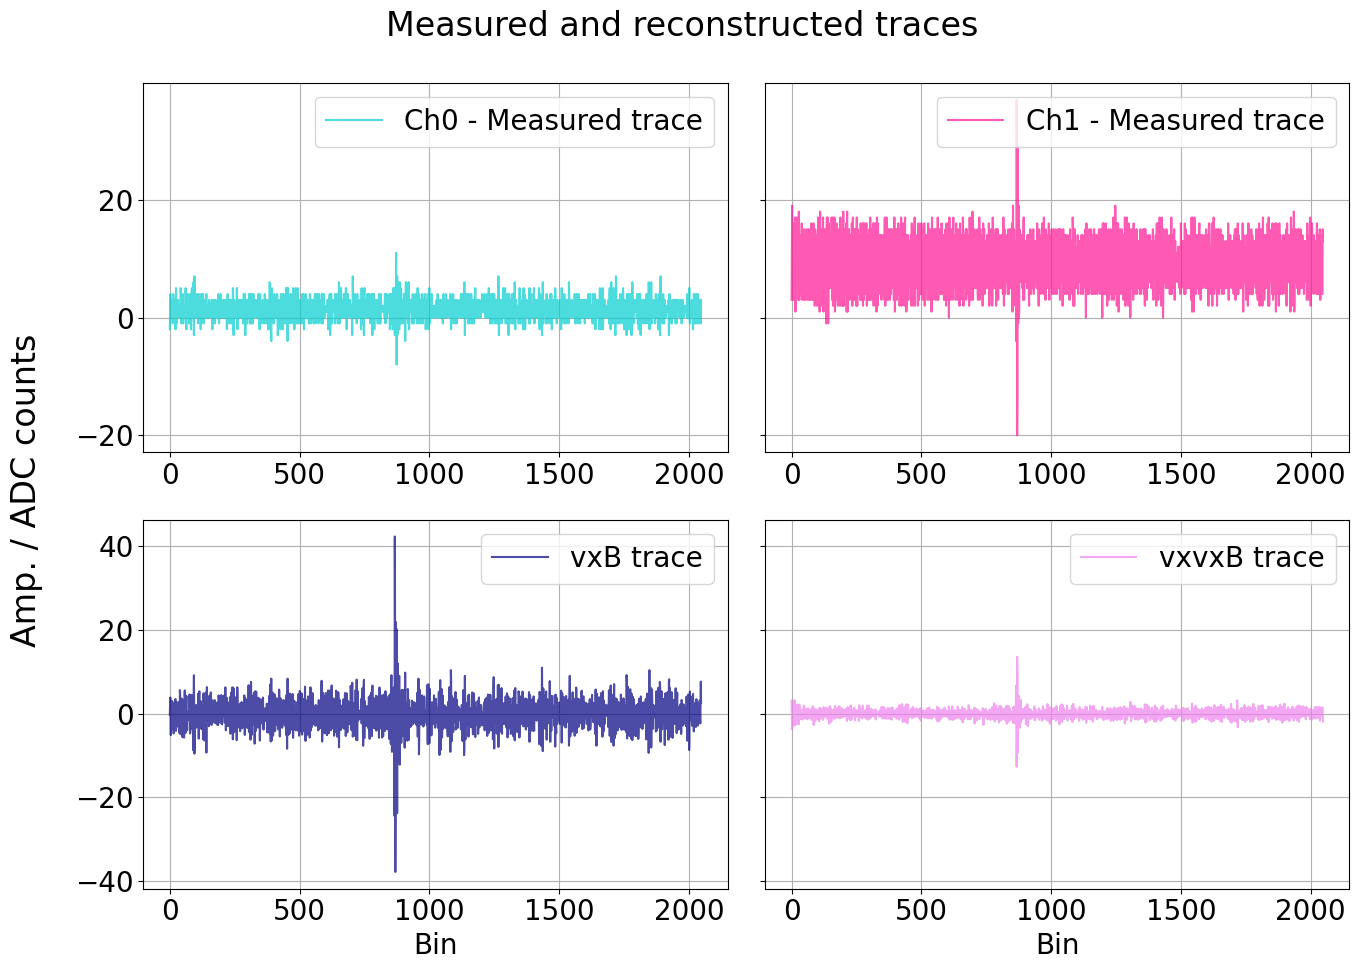

In [13]:
def project_to_shower_plane(trace_ew, trace_ns, zenith_deg, azimuth_deg):
    """

    Returns:
    --------
    E_geomagnetic : ndarray
        Signal along v × B direction
    E_radial : ndarray
        Signal along v × (v × B) direction
    """

    # Step 1: Shower axis unit vector (direction of incoming signal)
    theta = np.radians(zenith_deg)
    phi = np.radians(azimuth_deg)

    vx = np.sin(theta) * np.cos(phi)
    vy = np.sin(theta) * np.sin(phi)
    vz = np.cos(theta)
    v_hat = np.array([vx, vy, vz])  # direction of incoming shower

    # Step 2: Geomagnetic field (E, N, Z)
    B_vec = np.array([0.082, 0.231, -0.969])  # Approx. pointing N and downward
    B_vec = B_vec / np.linalg.norm(B_vec)

    # Step 3: Shower plane basis vectors
    e1 = np.cross(v_hat, B_vec)       # geomagnetic direction
    e1 /= np.linalg.norm(e1)
    e2 = np.cross(v_hat, e1)          # radial (Askaryan) direction
    e2 /= np.linalg.norm(e2)

    # Step 4: Build E-field vector in ground coords (E, N, Z)
    E_ground = np.stack([trace_ew, trace_ns, np.zeros_like(trace_ew)], axis=1)

    # Step 5: Project onto shower plane
    E_geomagnetic = E_ground @ e1
    E_radial = E_ground @ e2

    return E_geomagnetic, E_radial


trace_vxb, trace_vxvxb = project_to_shower_plane(signal_filtered_corrected_ch0, signal_filtered_corrected_ch1, data['sdrec']['theta'], data['sdrec']['phi'])

fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(nrows = 2, ncols= 2, figsize=(14, 10), sharey='row')

ax1.plot(rd['Ch0'], color = 'darkturquoise', alpha = 0.7, label = 'Ch0 - Measured trace')
ax3.plot(trace_vxb, color = 'navy', alpha = 0.7, label = 'vxB trace')

ax2.plot(rd['Ch1'], color = 'deeppink', alpha = 0.7, label = 'Ch1 - Measured trace')
ax4.plot(trace_vxvxb, color = 'violet', alpha = 0.7, label = 'vxvxB trace')

for ax in [ax1, ax2, ax3, ax4]:
    ax.grid()
    ax.legend()


ax3.set_xlabel('Bin')
ax4.set_xlabel('Bin')

fig.supylabel('Amp. / ADC counts')



plt.suptitle('Measured and reconstructed traces')
plt.tight_layout()
plt.show()


